## LLM

In [2]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, fuse_tokenized_corpus, chunk_corpus

import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import split_on_value



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.keras.mixed_precision.set_global_policy('mixed_float16')

c:\Users\krist\anaconda3\envs\keras-gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


RuntimeError: CPU dispatcher tracer already initlized

RuntimeError: CPU dispatcher tracer already initlized

RuntimeError: CPU dispatcher tracer already initlized

RuntimeError: CPU dispatcher tracer already initlized

RuntimeError: CPU dispatcher tracer already initlized

RuntimeError: CPU dispatcher tracer already initlized

Num GPUs Available:  1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4080, compute capability 8.9


In [18]:
tokenizer = pkl.load(open("tokenizers/tokenizer_superQA_24k.pkl", "rb"))
tokenizer.create_hash()
tokenizer.add_special_tokens(["<s>", "</s>", "<q>", "<a>","<pad>"])

In [19]:
def batch(corpus, batch_size=32):
    length = corpus.shape[1]

    batches = length // batch_size

    corpus = corpus[:, :batches * batch_size]

    corpus = tf.reshape(corpus, [-1, batch_size])
    return corpus


In [20]:
corpus_coqa_sqa = pkl.load(open('corpus/corpus_clean/corpus_coqa_sqa_24k_padded', 'rb'))
corpus_squad_sqa = pkl.load(open('corpus/corpus_clean/corpus_squad_sqa_24k_padded', 'rb'))
corpus_quac_sqa = pkl.load(open('corpus/corpus_clean/corpus_quac_sqa_24k_padded', 'rb'))

corpus_web_qa = pkl.load(open("corpus/corpus_clean/corpus_web_qa_24k", 'rb'))
corpus_web_qa = batch(corpus_web_qa, batch_size=768)

corpus_wiki_qa = pkl.load(open("corpus/corpus_clean/corpus_wiki_qa_24k", 'rb'))
corpus_wiki_qa = batch(corpus_wiki_qa, batch_size=768)

corpus_web_article = pkl.load(open("corpus/corpus_clean/corpus_web_article_24k", 'rb'))
corpus_web_article = batch(corpus_web_article, batch_size=768)

corpus_wiki_article = pkl.load(open("corpus/corpus_clean/corpus_wiki_article_24k", 'rb'))
corpus_wiki_article = batch(corpus_wiki_article, batch_size=768)

corpus_recipe = pkl.load(open("corpus/corpus_clean/corpus_recipe_24k", 'rb'))
corpus_recipe = batch(corpus_recipe, batch_size=768)

corpus_recipe_qa = pkl.load(open('corpus/corpus_clean/corpus_recipe_qa_24k', 'rb'))
corpus_recipe_qa = batch(corpus_recipe_qa, batch_size=768)

corpus_recipe_qa_ingred = pkl.load(open('corpus/corpus_clean/corpus_recipe_qa_ingred_24k', 'rb'))
corpus_recipe_qa_ingred = batch(corpus_recipe_qa_ingred, batch_size=768)

In [ ]:
print(corpus_coqa_sqa.shape)
print(corpus_squad_sqa.shape)
print(corpus_quac_sqa.shape)

print(corpus_web_qa.shape)
print(corpus_web_article.shape)
print(corpus_wiki_qa.shape)
print(corpus_wiki_article.shape)

print(corpus_recipe.shape)
print(corpus_recipe_qa.shape)
print(corpus_recipe_qa_ingred.shape)

(7199, 768)
(19035, 768)
(11567, 768)
(2495, 768)
(70687, 768)
(2026, 768)
(65387, 768)
(7252, 768)
(7594, 768)
(8356, 768)


In [22]:
print(np.sum(corpus_coqa_sqa[:1000]==-1))
print(np.sum(corpus_squad_sqa[:1000]==-1))
print(np.sum(corpus_quac_sqa[:1000]==-1))
print(np.sum(corpus_web_qa[:1000]==-1))
print(np.sum(corpus_web_article[:1000]==-1))
print(np.sum(corpus_wiki_qa[:1000]==-1))
print(np.sum(corpus_wiki_article[:1000]==-1))
print(np.sum(corpus_recipe[:1000]==-1))
print(np.sum(corpus_recipe_qa[:1000]==-1))
print(np.sum(corpus_recipe_qa_ingred[:1000]==-1))

0
0
0
0
0
0
0
0
0
0


In [23]:
corpus = tf.concat([corpus_coqa_sqa, 
                    corpus_squad_sqa, 
                    corpus_quac_sqa, 
                    corpus_web_qa, 
                    corpus_web_article, 
                    corpus_wiki_qa, 
                    corpus_wiki_article, 
                    corpus_recipe, 
                    corpus_recipe_qa,
                    corpus_recipe_qa_ingred], axis=0)

tf.random.set_seed(42)
corpus = tf.random.shuffle(corpus)
length = corpus.shape[0]
ratio = int(length * 0.95)

corpus_train = corpus[:ratio] 
corpus_test = corpus[ratio:]

print(length*768)

154827264


In [24]:
def data_pipeline(corpus, batch_size=32):
    samples = corpus.shape[0]

    steps_per_epoch = samples // batch_size
    
    ds = tf.data.Dataset.from_tensor_slices(corpus)
    ds = ds.repeat()
    ds = ds.shuffle(buffer_size=100*batch_size, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    
    return ds, steps_per_epoch

In [25]:
ds_train, steps_per_epoch = data_pipeline(corpus_train, batch_size=5)
ds_test,_ = data_pipeline(corpus_test, batch_size=1)

## Define Model

In [26]:
initial_lr = 1e-4
decay_steps = 60000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 1000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)

max_seq_len = 768
embed_dim = 896
tf_blocks = 14
heads = 14
ff_dim = 4*embed_dim
weight_decay = 0.025
dropout = 0.1

unembed_dims = []
accum_steps = 10

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    tokenizer=tokenizer,
                    lr=lr_schedule,
                    wd = weight_decay,
                    dropout=dropout,
                    accum_steps=accum_steps,
                    )

losses_train = []
losses_test = []


In [27]:
#name = "model_super_qa_larger"
name = "model_super_qa_expand"
ckpt = tf.train.Checkpoint(
    optimizer=model.opt,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/" + name,      # folder where ckpts are saved
    max_to_keep=5                         # only keep 5 latest checkpoints
)

In [28]:
ckpt.restore(ckpt_manager.latest_checkpoint)
losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

In [29]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")
print(model.accum_steps)

Total number of parameters: 157298091
tf.Tensor(10, shape=(), dtype=int32)


In [30]:
def train_loop(iter_train, iter_test, steps_per_epoch, epochs):
    for i in tqdm(range(steps_per_epoch//accum_steps*epochs)):
        loss_train_temp = 0
        loss_test_temp = 0
        for _ in range(accum_steps):
            batch_train = next(iter_train)
            batch_test = next(iter_test)
            
            loss_train_temp += model.train_step(batch_train).numpy()
            
            if i % 25 == 0:
                loss_test_temp += model.evaluate(batch_test).numpy()
            
        losses_train.append(loss_train_temp/accum_steps)

        if i % 25 == 0:
            losses_test.append(loss_test_temp/accum_steps)
        else:
            losses_test.append(losses_test[-1])

        if (i+1) % 500 == 0:
            ckpt_manager.save()
            pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))

    
        lr = model.opt.inner_optimizer._decayed_lr(tf.float32).numpy()
        print(f"Step {i+1}, Loss Train: {losses_train[-1]:.4f}, Loss Test: {losses_test[-1]:.4f}, LR: {lr:.6f}")
    ckpt_manager.save()
    pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))
    return losses_train, losses_test

In [31]:
iter_train = iter(ds_train)
iter_test = iter(ds_test)

In [42]:
train_loop(iter_train, iter_test, steps_per_epoch, 1)

  0%|          | 0/3830 [00:00<?, ?it/s]

Step 1, Loss Train: 3.0748, Loss Test: 2.5555, LR: 0.000051
Step 2, Loss Train: 3.2989, Loss Test: 2.5555, LR: 0.000051
Step 3, Loss Train: 3.1809, Loss Test: 2.5555, LR: 0.000051
Step 4, Loss Train: 3.1435, Loss Test: 2.5555, LR: 0.000051
Step 5, Loss Train: 3.1063, Loss Test: 2.5555, LR: 0.000051
Step 6, Loss Train: 2.9866, Loss Test: 2.5555, LR: 0.000051
Step 7, Loss Train: 3.0846, Loss Test: 2.5555, LR: 0.000051
Step 8, Loss Train: 2.8301, Loss Test: 2.5555, LR: 0.000051
Step 9, Loss Train: 3.3018, Loss Test: 2.5555, LR: 0.000051
Step 10, Loss Train: 3.1562, Loss Test: 2.5555, LR: 0.000051
Step 11, Loss Train: 3.2967, Loss Test: 2.5555, LR: 0.000051
Step 12, Loss Train: 3.0919, Loss Test: 2.5555, LR: 0.000051
Step 13, Loss Train: 3.1548, Loss Test: 2.5555, LR: 0.000051
Step 14, Loss Train: 3.1811, Loss Test: 2.5555, LR: 0.000051
Step 15, Loss Train: 3.0681, Loss Test: 2.5555, LR: 0.000051
Step 16, Loss Train: 3.1393, Loss Test: 2.5555, LR: 0.000051
Step 17, Loss Train: 3.1191, Loss

KeyboardInterrupt: 

In [43]:
ckpt_manager.save()
pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))

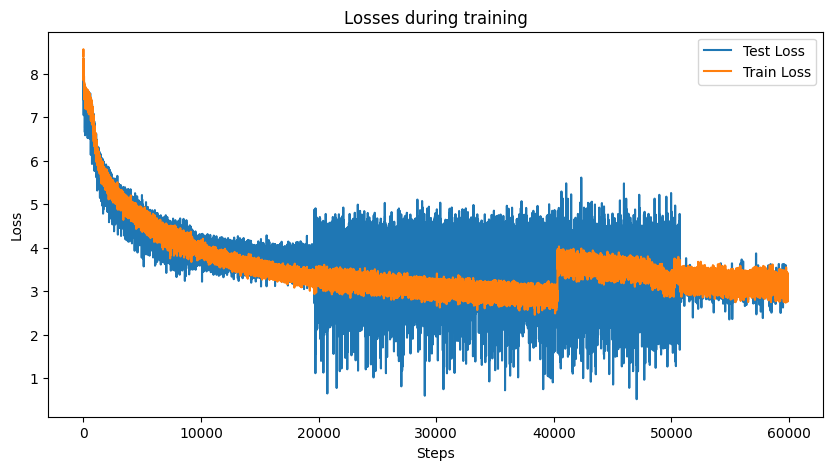

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(losses_test[100:], label="Test Loss")
plt.plot(losses_train[100:], label="Train Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Losses during training")
plt.legend()
plt.show()

In [35]:
text = "<s>John is in the house. Sarah is in the garden.<q> Where is John?"
text = text.lower()
tokens = tf.cast(tokenizer.encode(text), tf.int32)

In [50]:
import textwrap
import ipywidgets as widgets
from IPython.display import display, HTML

display(HTML("""
<style>
.widget-textarea textarea {
    background-color: #2e2e2e !important;
    color: #f1f1f1 !important;
    border: 1px solid #555 !important;
}
</style>
"""))

wrapper = textwrap.TextWrapper(width=80)

# create a read-only text area
ta = widgets.Textarea(
    value="",
    layout=widgets.Layout(width='80ch', height='20em'),
    disabled=True
)
display(ta)

#text = "<s>Recipe for Obama Burger: Ingredients: "
#text = "<s>Recipe for Obama Burger: Ingredients: "
#text = "<s>Make me a recipe for baked fish?<a>"
#text = "<s>John is in the house. Sarah is in the garden.<q>Where is John?"
text = "<s>John is in the house. Sarah is in the garden.<q>Where is Sarah?"
#text = "<s>The apple is green. The banana is yellow. The tomato is red.<q> What color is the banana?"
#text = "<s>The apple is green. The banana is yellow. The tomato is red.<q> What color is the banana?"
#text = "<s><q>Who is Midna?<a>"
#text = "<s><q>Name two presidents?<a>"
#text = "<s><q>name two presidents?<a>george washington (1789-1832) and john adams.<q>tell me more about john adams.<a>"
#text = "<s>Fred went to school. Then he went to church. Then he went home.<q>Where did Fred go after school?<a>"
#text = "<s><q>Name a famous dictator.<a>"
#text = "<s><q>Give me a long answer?<a>"
#text = "<s><q>Who is the vocalist of coldplay?<a>"
#text = "<s>cnn"
#text = "<s><q>Why was hitler bad?<a>"
#text = "<s><q>Name many colors?<a>"
#text = "<s><q>Name a leader?<a>"
#text = "<s><q>Name an illness?<a>police poisoning<q>what is that?<a>"
text = text.lower()
tokens = tf.cast(tokenizer.encode(text), tf.int32)

T = 1
k = 50


for i in range(1024):
    logits = model.call(tokens)[0, -1:]
    topk_vals, _      = tf.math.top_k(logits, k=k)
    kth_value         = topk_vals[:,-1]

    logits = tf.where(logits >= kth_value, logits, tf.constant(-np.inf, logits.dtype))

    idx = tf.cast(
        tf.random.categorical(logits / T, num_samples=1),
        tf.int32
    ) 
    tokens = tf.concat([tokens, idx], axis=1)

    text_pred = (
        tokenizer
        .decode(tokens)
        .numpy()[0]
        .decode('utf-8')
        .replace("\n", " ")
    )
    ta.value = wrapper.fill(text_pred)  # this updates in-place

    if idx[0, 0] == tokenizer.token_to_idx["</s>"]:# or idx[0, 0] == tokenizer.token_to_idx["<q>"]:
        break

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "c:\Users\krist\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2761, in while_loop
    while cond(*loop_vars):  File "c:\Users\krist\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2753, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "c:\Users\krist\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\functional_ops.py", line 655, in compute
    return (next_i, flat_a_out, tas)  File "c:\Users\krist\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\functional_ops.py", line 650, in <listcomp>
    tas = [ta.write(i, value) for (ta, value) in zip(tas, flat_a_out)]  File "c:\Users\krist\anaconda3\envs\keras-gpu\lib\s

KeyboardInterrupt: 

In [3]:
name = "model_super_qa_very_large_expandedData"
losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

In [28]:
def moving_average(x, w=100):
    return np.convolve(x, np.ones(w), 'valid') / w

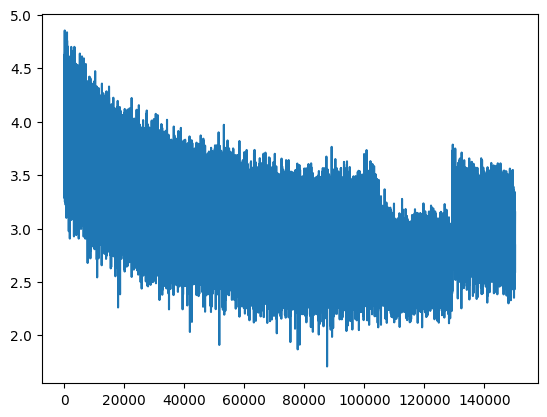

In [32]:
plt.plot(moving_average(losses_train[10000:], w=1), label="Train Loss")

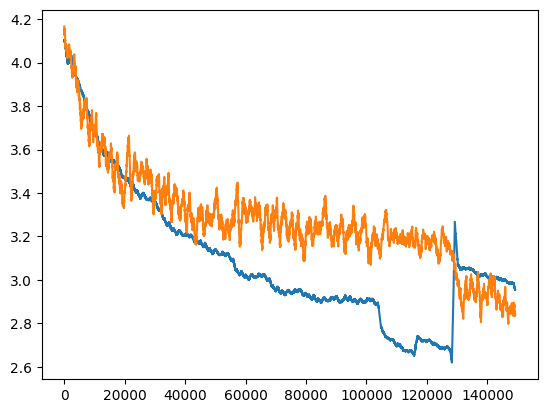

In [42]:
plt.plot(moving_average(losses_train[10000:], w=1000), label="Train Loss")
plt.plot(moving_average(losses_test[10000:], w=1000), label="Test Loss")

In [7]:
losses_train[-200:]

[2.656181789934635,
 3.180048368871212,
 2.648307003080845,
 2.8091074526309967,
 2.7767815962433815,
 2.982430912554264,
 2.950876262038946,
 2.779323920607567,
 3.027226835489273,
 3.3451629877090454,
 2.8125762343406677,
 2.749489575624466,
 2.6862537190318108,
 3.1763921305537224,
 2.7770859450101852,
 2.836370460689068,
 3.05386471003294,
 3.0250463485717773,
 2.7532372027635574,
 3.173467233777046,
 2.8842009976506233,
 2.9249716848134995,
 2.8063819482922554,
 2.9207066893577576,
 2.8392259255051613,
 3.072015233337879,
 2.6695745289325714,
 3.064947657287121,
 3.0534869581460953,
 2.9483791887760162,
 2.760186418890953,
 2.992857165634632,
 3.0671394169330597,
 2.811779238283634,
 2.9837295338511467,
 3.2271327078342438,
 3.071956805884838,
 3.0089734606444836,
 2.8821495696902275,
 3.0831585377454758,
 2.4319462701678276,
 2.9966388195753098,
 2.986316926777363,
 3.200283482670784,
 2.807615615427494,
 3.0506905019283295,
 2.8199987560510635,
 2.8519651144742966,
 2.9968732744